In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from braindecode.models import EEGNetv4
import copy
import random
import pandas as pd
from tqdm import notebook
import tqdm
from pathlib import Path
import seaborn as sns
import scipy

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\machi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
c:\Users\machi\anaconda3\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be ab

'NVIDIA GeForce GTX 1650'

# Utility functions

In [2]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    load_data_from_users,
)

In [3]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = -float("inf")
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

# Leave-one-user-out Cross Validation

Deixa um usuário de fora e treina em todos os outros

In [ ]:
frequencias_e_fases = scipy.io.loadmat(
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
frequencias = frequencias_e_fases["freqs"]
frequencias = np.round(frequencias, 2).ravel()
fases = frequencias_e_fases["phases"]

# Parâmetros de filtragem
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6

# Parâmetros de pré-processamento
sample_rate = 250
delay = 160  # 160 amostras, 0,5s (sem estimulação) + 0,14s (latencia para começo da evocação)

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 0.4
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))

# Eletrodos e frequências de interesse
occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 1000
exp_dir = Path(
    f"eegnet/{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [5]:
print("Usuários de interesse:", users)
print("Frequências de interesse:", frequencias_desejadas)
print("Indices das frequências de interesse:", indices)

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequências de interesse: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Indices das frequências de interesse: [0, 1, 2, 3, 4, 5, 6, 7]


In [6]:
all_data = load_data_from_users(
    users=users,
    visual_delay=delay,
    filter_bandpass=True,
    sample_rate=sample_rate,
    freq_cut_low=freq_cut_low,
    freq_cut_high=freq_cut_high,
    filter_order=filter_order,
)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

Processando Usuário 1
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1757, Train Accuracy: 0.1199, Val Loss: 2.0890, Val Accuracy: 0.0769
Epoch 2/1000: Train Loss: 2.1418, Train Accuracy: 0.1008, Val Loss: 2.0862, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.1422, Train Accuracy: 0.1308, Val Loss: 2.0839, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1362, Train Accuracy: 0.1335, Val Loss: 2.0819, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.1581, Train Accuracy: 0.1417, Val Loss: 2.0801, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1284, Train Accuracy: 0.1444, Val Loss: 2.0784, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.1247, Train Accuracy: 0.1553, Val Loss: 2.0768, Val Accuracy: 0.1385
Epoch 8/1000: Train Loss: 2.1264, Train Accuracy: 0.1335, Val Loss: 2.0753, Val Accuracy: 0.1385
Epoch 9/1000: Train Loss: 2.1145, Train Accuracy: 0.1362, Val Loss: 2.0739, Val Accuracy: 0.1385
Epoch 10/1000: Train Loss: 2.1253, Train Accuracy: 0.1471, Val Loss: 2.0726, Val Accuracy: 0.1231
Epoch 11/1000: Train Loss: 2.

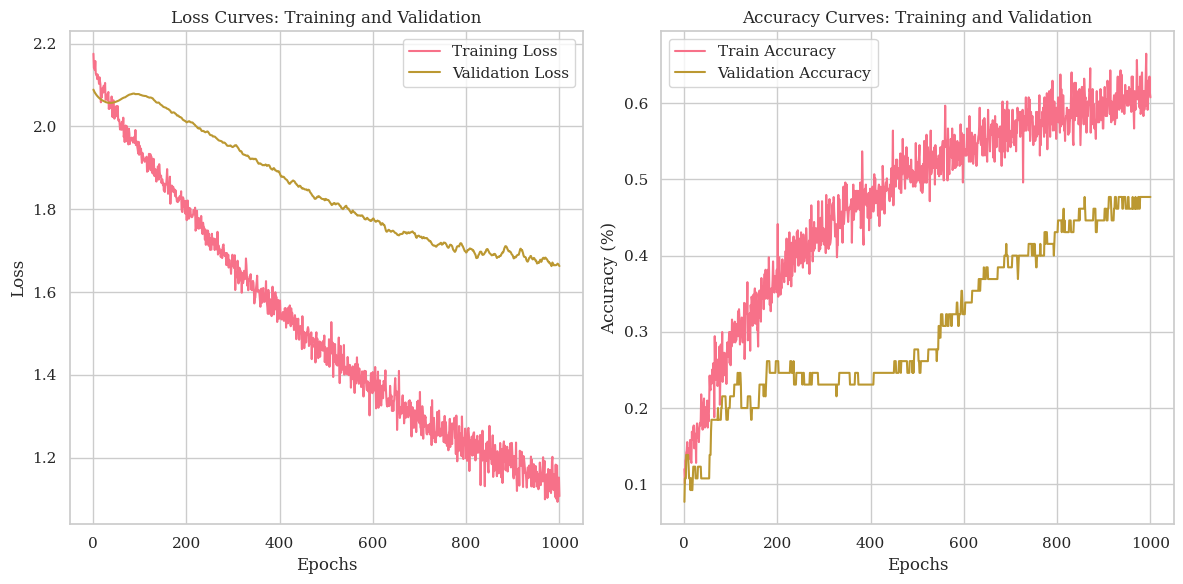

Test set Accuracy: 0.4583
Recall: 0.4583
F1 Score: 0.4509


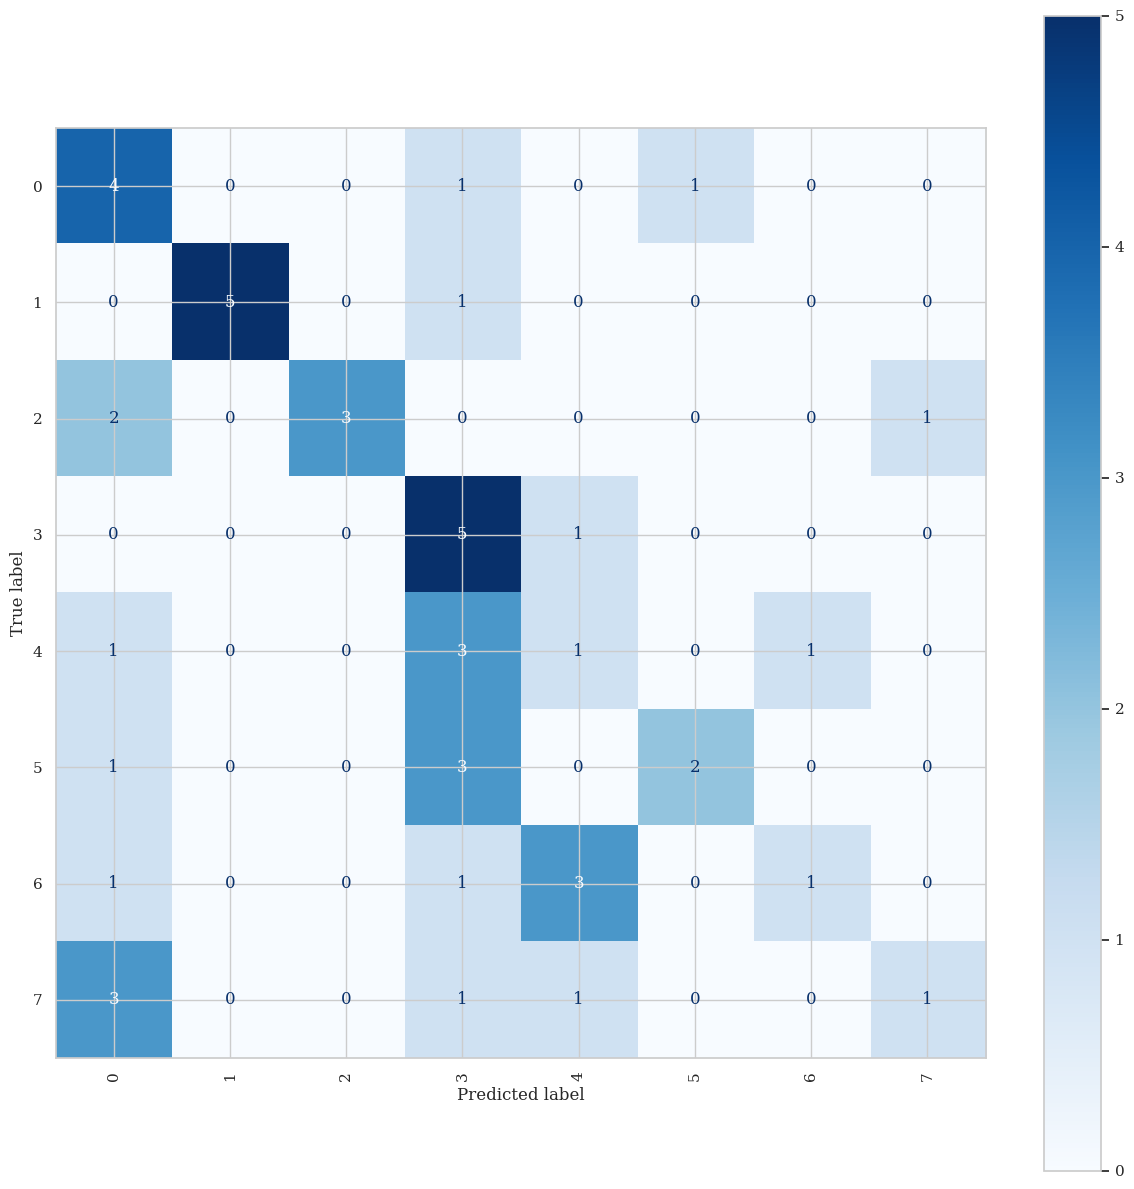

Usuário 1 Finalizado: Acurácia=0.4583, Recall=0.4583, F1=0.4509
--------------------------------------------------
Processando Usuário 2
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1368, Train Accuracy: 0.1744, Val Loss: 2.0798, Val Accuracy: 0.1692
Epoch 2/1000: Train Loss: 2.1638, Train Accuracy: 0.1063, Val Loss: 2.0791, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1623, Train Accuracy: 0.1499, Val Loss: 2.0784, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1176, Train Accuracy: 0.1444, Val Loss: 2.0777, Val Accuracy: 0.1231
Epoch 5/1000: Train Loss: 2.1429, Train Accuracy: 0.1253, Val Loss: 2.0770, Val Accuracy: 0.1231
Epoch 6/1000: Train Loss: 2.1132, Train Accuracy: 0.1444, Val Loss: 2.0763, Val Accuracy: 0.1231
Epoch 7/1000: Train Loss: 2.1265, Train Accuracy: 0.1580, Val Loss: 2.0756, Val Accuracy: 0.1385
Epoch 8/1000: Train Loss: 2.1368, Train Accuracy: 0.1608, Val Loss: 2.0749, Val Accuracy: 0.1385
Epoch 9/1000: Train Loss: 2.1415, Train Accuracy: 0.1253, Val Loss: 2.0742, Val Accuracy: 0.1231
Epoch 10/1000: Train Loss: 2.1206, Train Accuracy: 0.1444, Val Loss: 2.0735, Val Accuracy: 0.1231
Epoch 11/1000: Train Loss: 2.

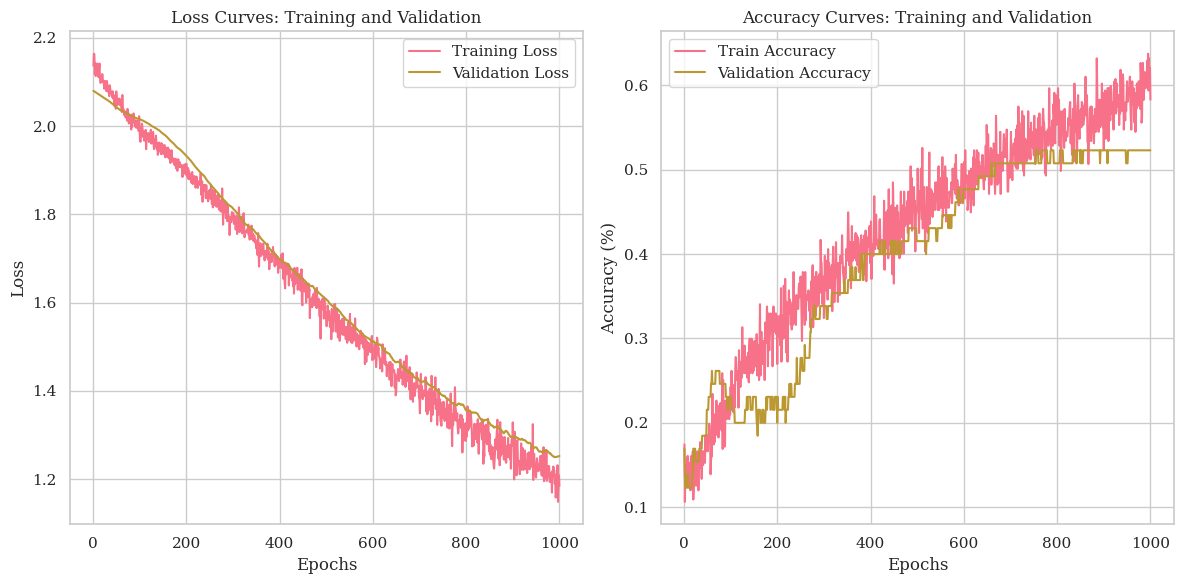

Test set Accuracy: 0.4375
Recall: 0.4375
F1 Score: 0.4259


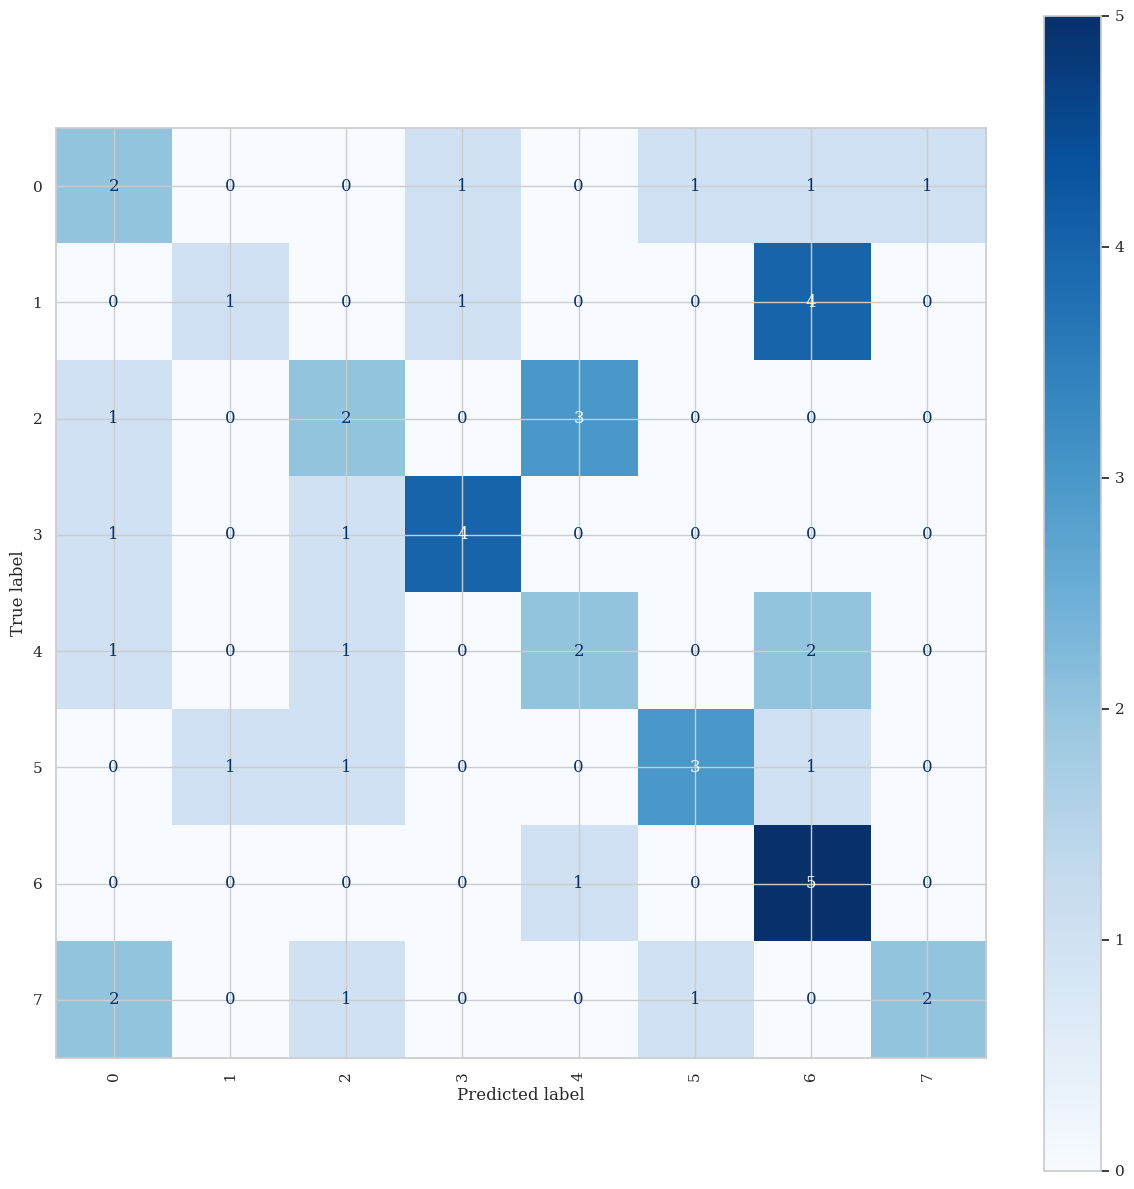

Usuário 2 Finalizado: Acurácia=0.4375, Recall=0.4375, F1=0.4259
--------------------------------------------------
Processando Usuário 3
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1483, Train Accuracy: 0.1035, Val Loss: 2.0800, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1461, Train Accuracy: 0.1281, Val Loss: 2.0804, Val Accuracy: 0.1692
Epoch 3/1000: Train Loss: 2.1589, Train Accuracy: 0.1063, Val Loss: 2.0808, Val Accuracy: 0.1846
Epoch 4/1000: Train Loss: 2.1178, Train Accuracy: 0.1335, Val Loss: 2.0812, Val Accuracy: 0.1846
Epoch 5/1000: Train Loss: 2.1345, Train Accuracy: 0.1444, Val Loss: 2.0816, Val Accuracy: 0.1846
Epoch 6/1000: Train Loss: 2.1593, Train Accuracy: 0.1144, Val Loss: 2.0821, Val Accuracy: 0.1692
Epoch 7/1000: Train Loss: 2.1516, Train Accuracy: 0.1144, Val Loss: 2.0826, Val Accuracy: 0.1692
Epoch 8/1000: Train Loss: 2.1481, Train Accuracy: 0.1035, Val Loss: 2.0831, Val Accuracy: 0.1538
Epoch 9/1000: Train Loss: 2.1532, Train Accuracy: 0.1417, Val Loss: 2.0836, Val Accuracy: 0.1692
Epoch 10/1000: Train Loss: 2.1687, Train Accuracy: 0.0954, Val Loss: 2.0841, Val Accuracy: 0.1538
Epoch 11/1000: Train Loss: 2.

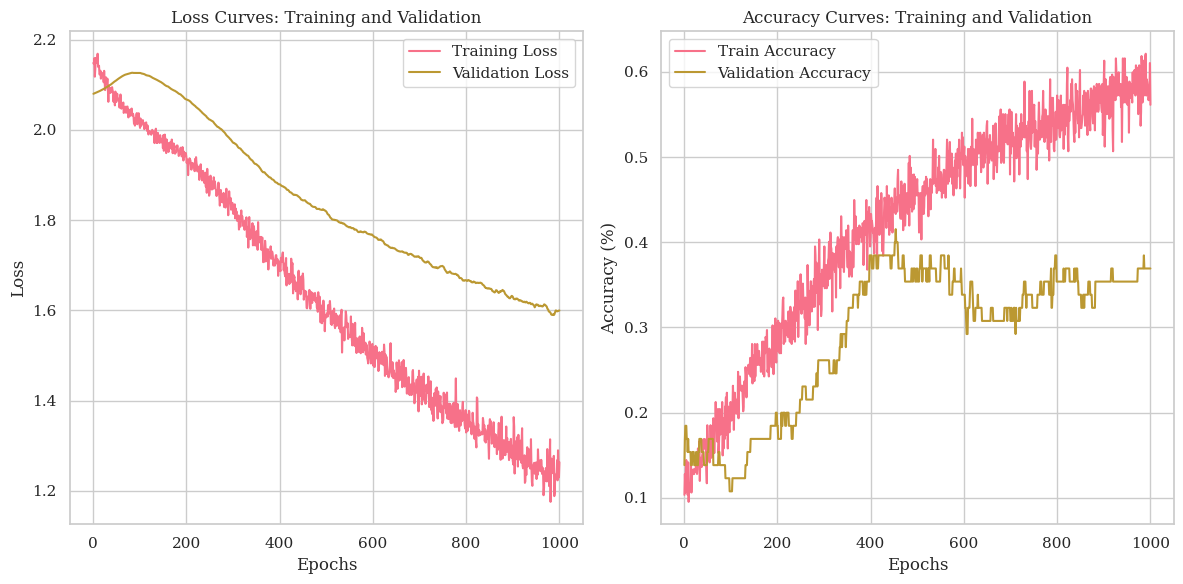

Test set Accuracy: 0.6458
Recall: 0.6458
F1 Score: 0.6367


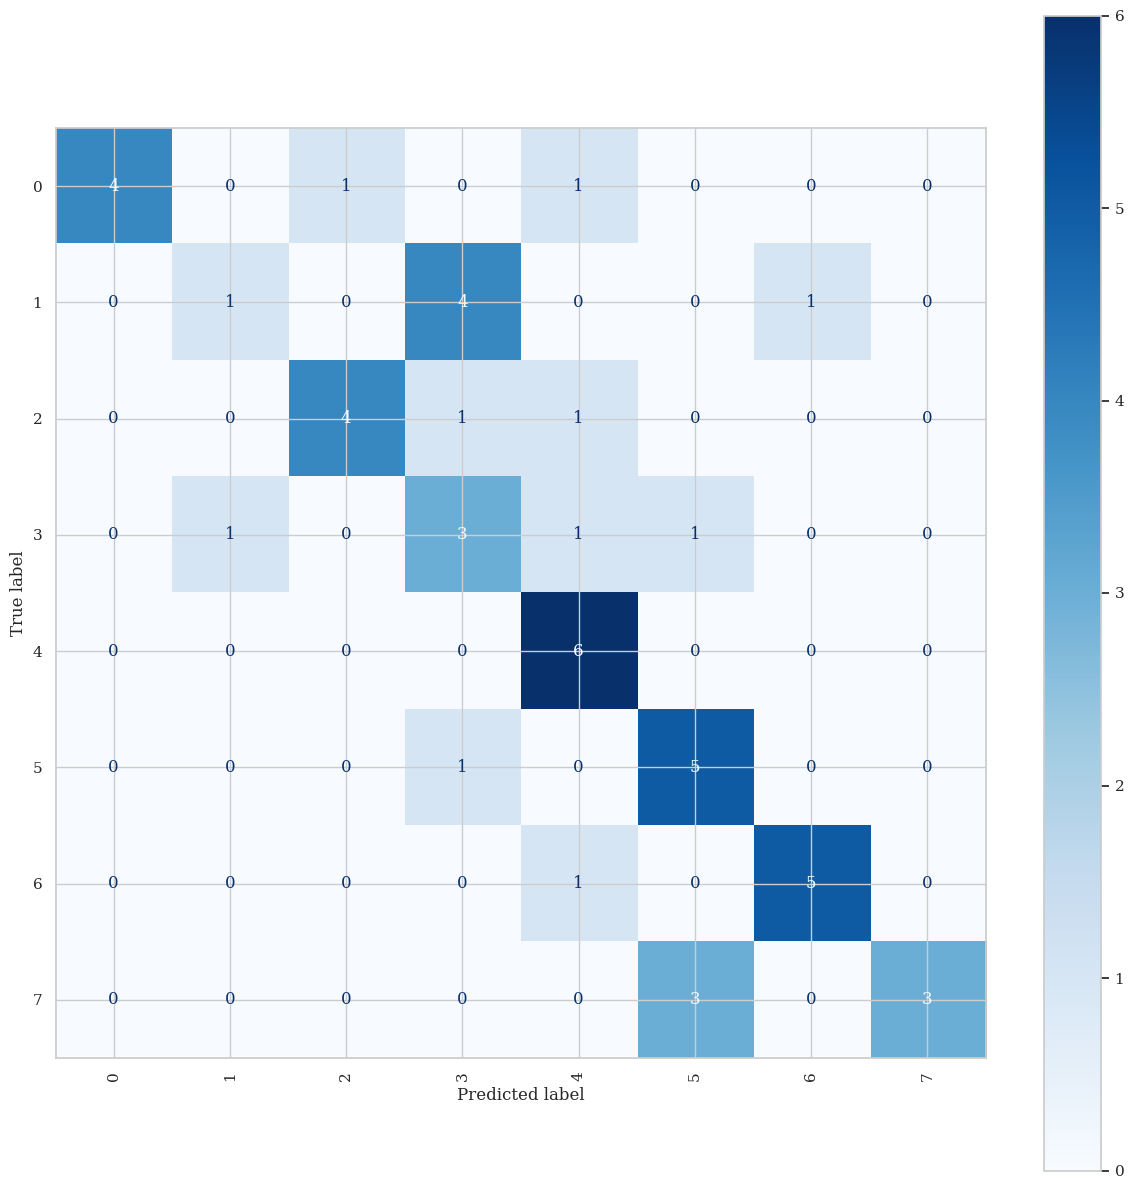

Usuário 3 Finalizado: Acurácia=0.6458, Recall=0.6458, F1=0.6367
--------------------------------------------------
Processando Usuário 4
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1288, Train Accuracy: 0.1335, Val Loss: 2.0812, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1518, Train Accuracy: 0.1172, Val Loss: 2.0820, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1458, Train Accuracy: 0.1172, Val Loss: 2.0827, Val Accuracy: 0.1538
Epoch 4/1000: Train Loss: 2.1457, Train Accuracy: 0.1008, Val Loss: 2.0834, Val Accuracy: 0.1538
Epoch 5/1000: Train Loss: 2.1486, Train Accuracy: 0.1253, Val Loss: 2.0841, Val Accuracy: 0.1538
Epoch 6/1000: Train Loss: 2.1432, Train Accuracy: 0.1172, Val Loss: 2.0848, Val Accuracy: 0.1538
Epoch 7/1000: Train Loss: 2.1161, Train Accuracy: 0.1117, Val Loss: 2.0855, Val Accuracy: 0.1538
Epoch 8/1000: Train Loss: 2.1539, Train Accuracy: 0.0899, Val Loss: 2.0861, Val Accuracy: 0.1231
Epoch 9/1000: Train Loss: 2.1429, Train Accuracy: 0.1117, Val Loss: 2.0868, Val Accuracy: 0.0769
Epoch 10/1000: Train Loss: 2.1421, Train Accuracy: 0.1144, Val Loss: 2.0874, Val Accuracy: 0.0769
Epoch 11/1000: Train Loss: 2.

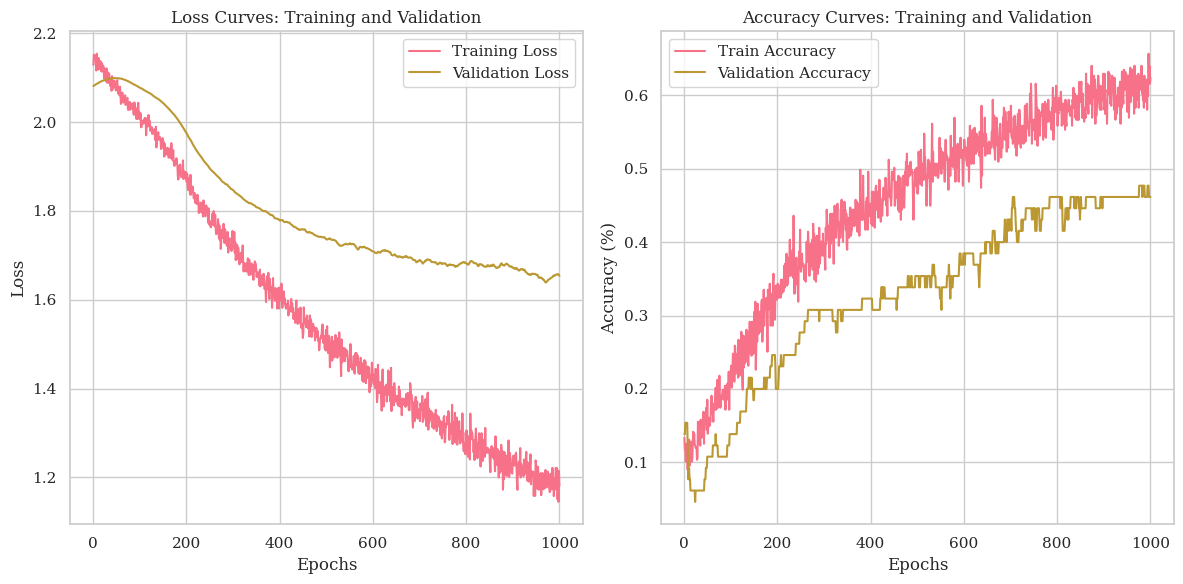

Test set Accuracy: 0.1250
Recall: 0.1250
F1 Score: 0.0935


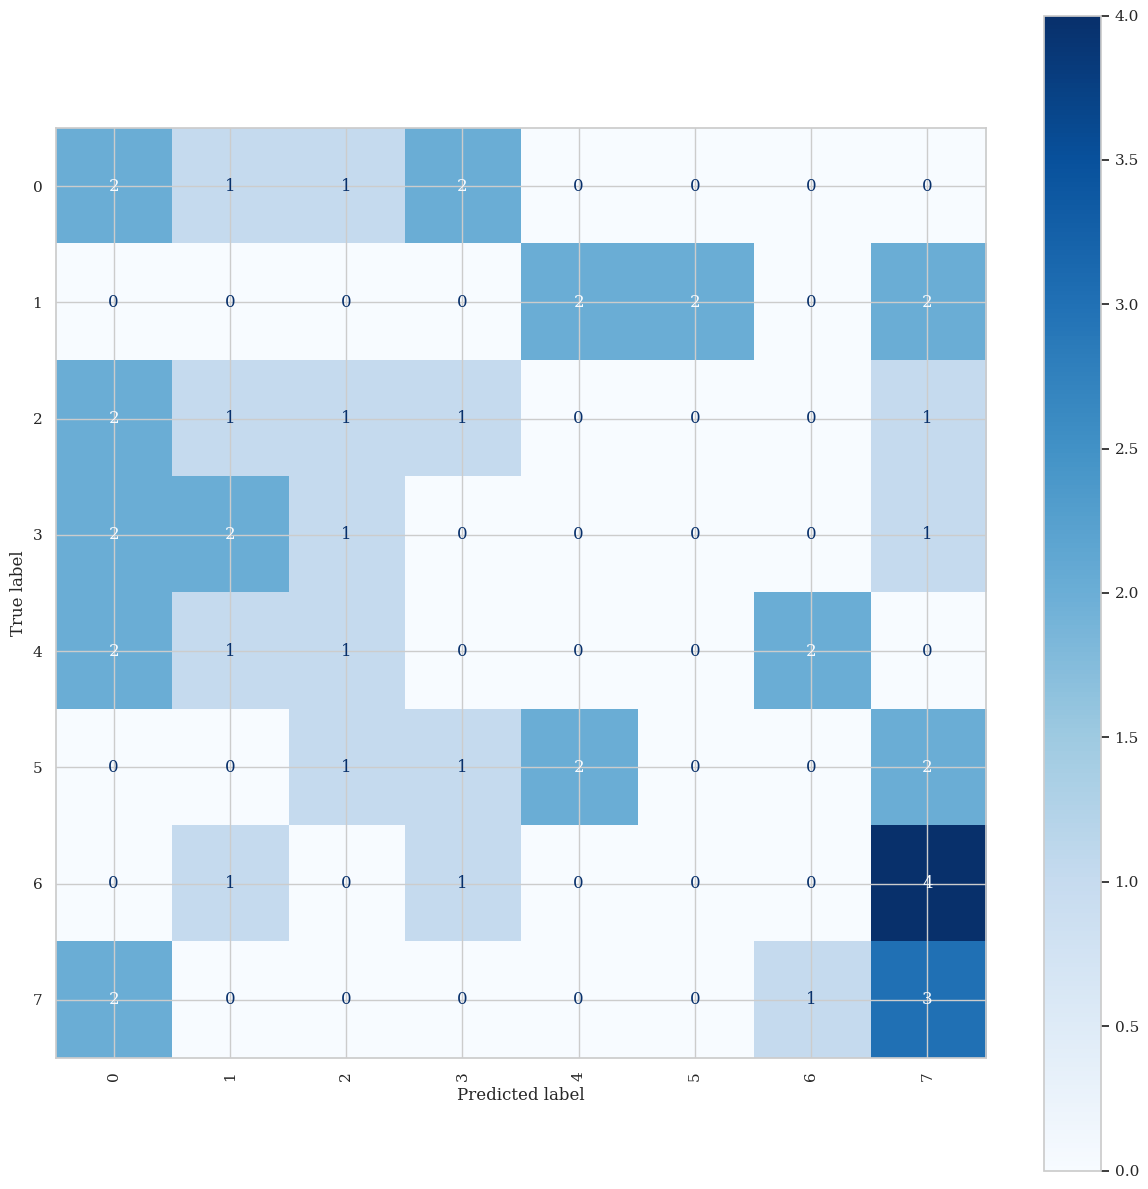

Usuário 4 Finalizado: Acurácia=0.1250, Recall=0.1250, F1=0.0935
--------------------------------------------------
Processando Usuário 5
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1001, Train Accuracy: 0.1199, Val Loss: 2.0783, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1239, Train Accuracy: 0.0954, Val Loss: 2.0789, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1226, Train Accuracy: 0.1281, Val Loss: 2.0795, Val Accuracy: 0.1692
Epoch 4/1000: Train Loss: 2.1088, Train Accuracy: 0.1444, Val Loss: 2.0802, Val Accuracy: 0.1692
Epoch 5/1000: Train Loss: 2.1359, Train Accuracy: 0.0926, Val Loss: 2.0808, Val Accuracy: 0.1538
Epoch 6/1000: Train Loss: 2.1184, Train Accuracy: 0.1199, Val Loss: 2.0815, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.1325, Train Accuracy: 0.1144, Val Loss: 2.0821, Val Accuracy: 0.1385
Epoch 8/1000: Train Loss: 2.1074, Train Accuracy: 0.1090, Val Loss: 2.0827, Val Accuracy: 0.1385
Epoch 9/1000: Train Loss: 2.0864, Train Accuracy: 0.1226, Val Loss: 2.0834, Val Accuracy: 0.1385
Epoch 10/1000: Train Loss: 2.1046, Train Accuracy: 0.1035, Val Loss: 2.0840, Val Accuracy: 0.1385
Epoch 11/1000: Train Loss: 2.

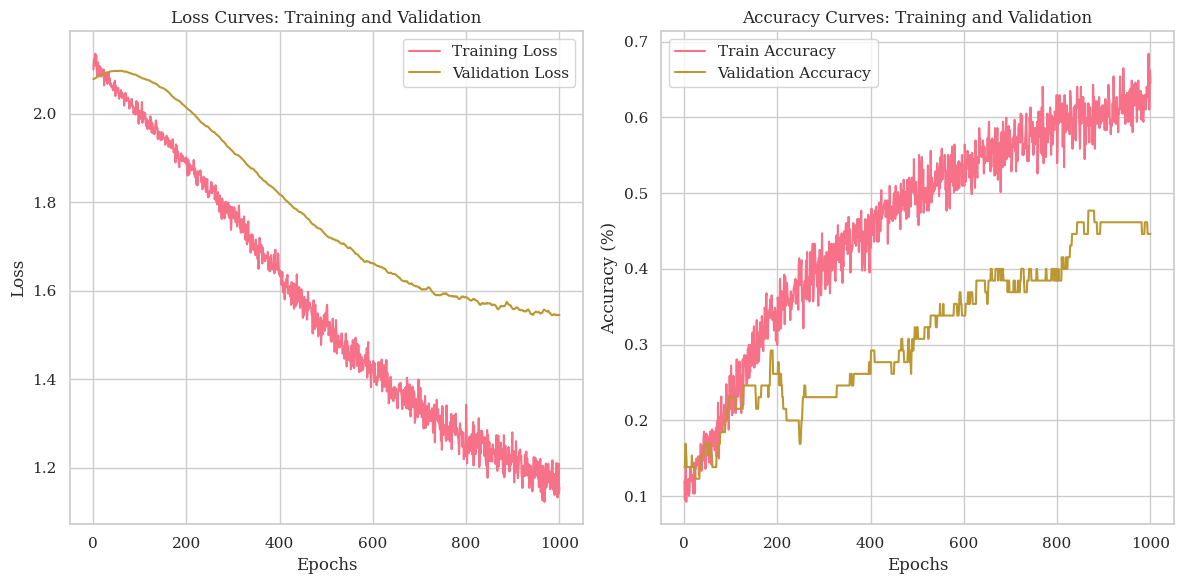

Test set Accuracy: 0.5417
Recall: 0.5417
F1 Score: 0.5460


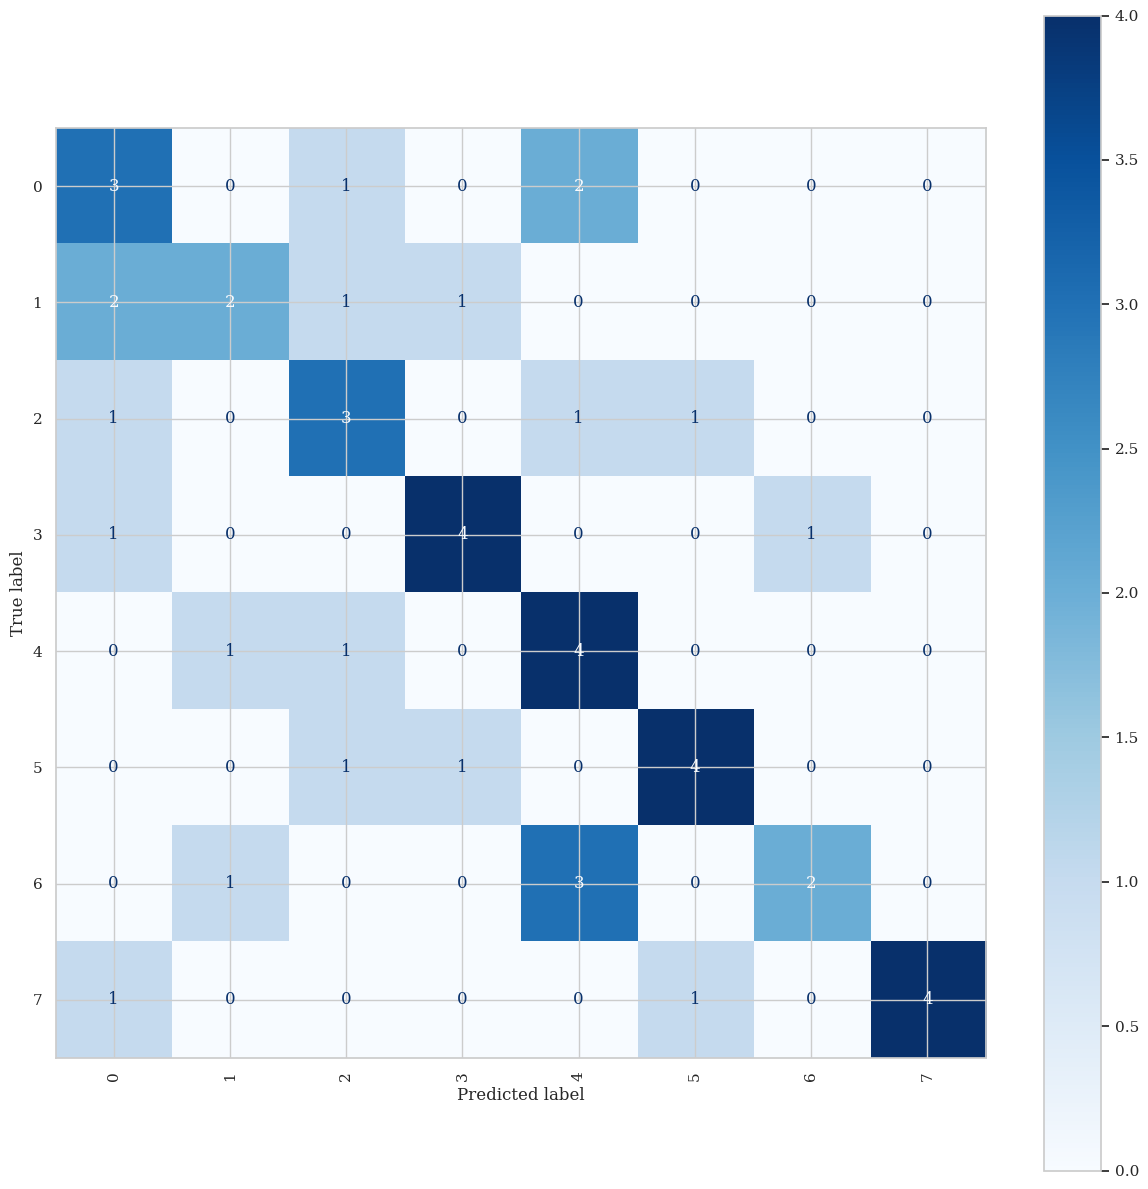

Usuário 5 Finalizado: Acurácia=0.5417, Recall=0.5417, F1=0.5460
--------------------------------------------------
Processando Usuário 6
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1401, Train Accuracy: 0.1281, Val Loss: 2.0819, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1398, Train Accuracy: 0.1308, Val Loss: 2.0825, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1668, Train Accuracy: 0.1117, Val Loss: 2.0831, Val Accuracy: 0.1385
Epoch 4/1000: Train Loss: 2.1391, Train Accuracy: 0.1308, Val Loss: 2.0838, Val Accuracy: 0.1538
Epoch 5/1000: Train Loss: 2.1448, Train Accuracy: 0.1199, Val Loss: 2.0846, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1649, Train Accuracy: 0.0954, Val Loss: 2.0853, Val Accuracy: 0.1077
Epoch 7/1000: Train Loss: 2.1414, Train Accuracy: 0.1444, Val Loss: 2.0859, Val Accuracy: 0.1231
Epoch 8/1000: Train Loss: 2.1379, Train Accuracy: 0.1499, Val Loss: 2.0865, Val Accuracy: 0.1077
Epoch 9/1000: Train Loss: 2.1405, Train Accuracy: 0.1417, Val Loss: 2.0871, Val Accuracy: 0.0923
Epoch 10/1000: Train Loss: 2.1774, Train Accuracy: 0.1090, Val Loss: 2.0877, Val Accuracy: 0.0923
Epoch 11/1000: Train Loss: 2.

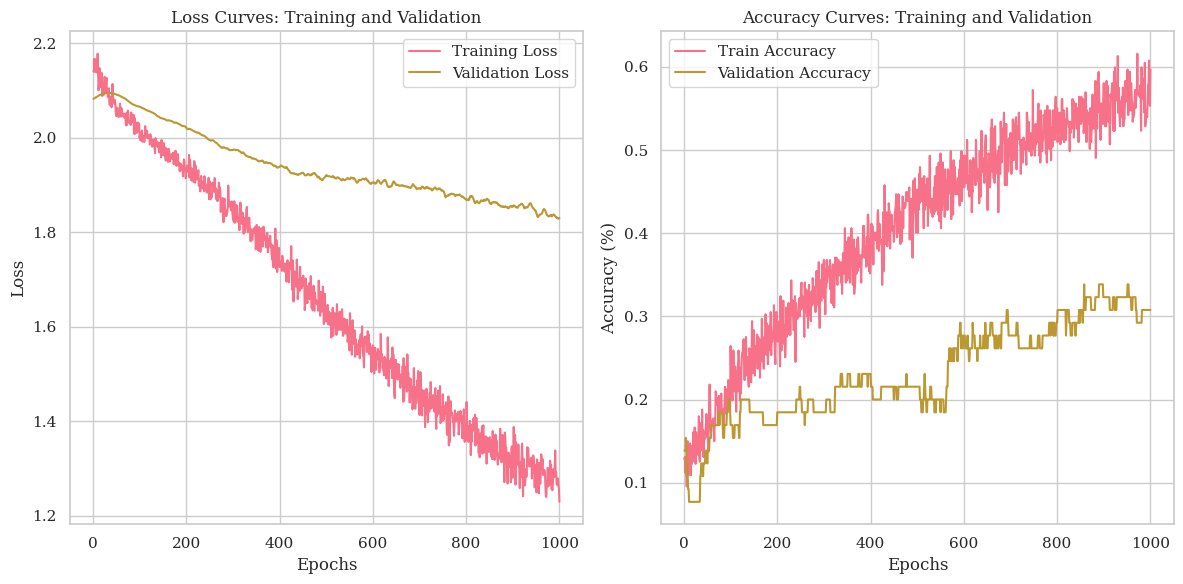

Test set Accuracy: 0.4792
Recall: 0.4792
F1 Score: 0.4482


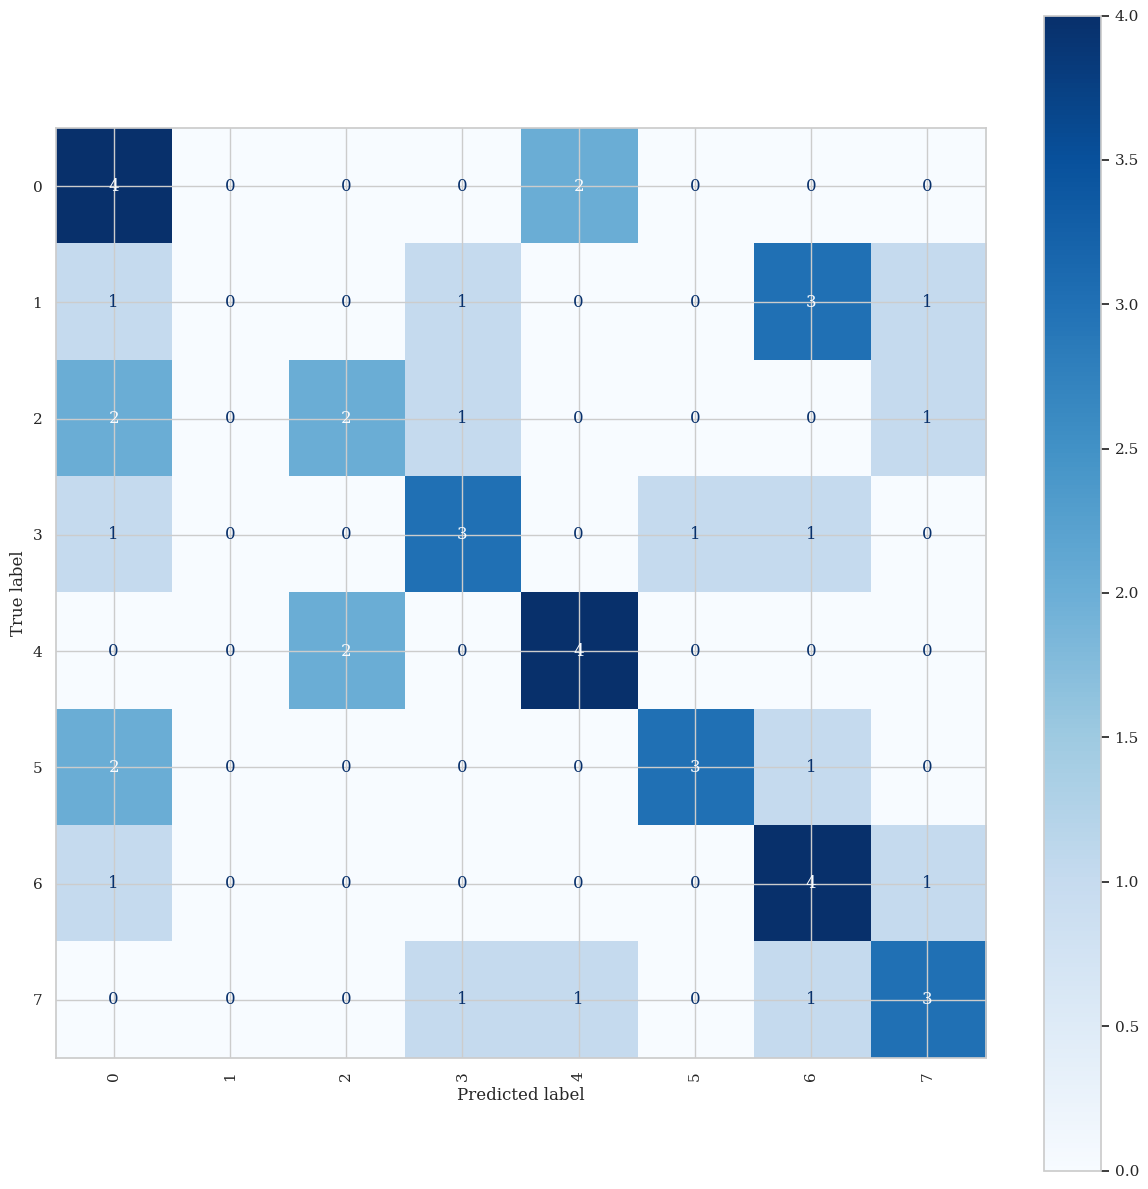

Usuário 6 Finalizado: Acurácia=0.4792, Recall=0.4792, F1=0.4482
--------------------------------------------------
Processando Usuário 7
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.2039, Train Accuracy: 0.1144, Val Loss: 2.0813, Val Accuracy: 0.1538
Epoch 2/1000: Train Loss: 2.1666, Train Accuracy: 0.1117, Val Loss: 2.0822, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1551, Train Accuracy: 0.1308, Val Loss: 2.0831, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1679, Train Accuracy: 0.1172, Val Loss: 2.0840, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.1688, Train Accuracy: 0.1035, Val Loss: 2.0848, Val Accuracy: 0.0923
Epoch 6/1000: Train Loss: 2.1765, Train Accuracy: 0.1471, Val Loss: 2.0857, Val Accuracy: 0.1077
Epoch 7/1000: Train Loss: 2.1732, Train Accuracy: 0.1117, Val Loss: 2.0865, Val Accuracy: 0.1077
Epoch 8/1000: Train Loss: 2.1692, Train Accuracy: 0.1117, Val Loss: 2.0874, Val Accuracy: 0.1077
Epoch 9/1000: Train Loss: 2.1552, Train Accuracy: 0.1281, Val Loss: 2.0881, Val Accuracy: 0.1077
Epoch 10/1000: Train Loss: 2.1559, Train Accuracy: 0.1417, Val Loss: 2.0889, Val Accuracy: 0.0923
Epoch 11/1000: Train Loss: 2.

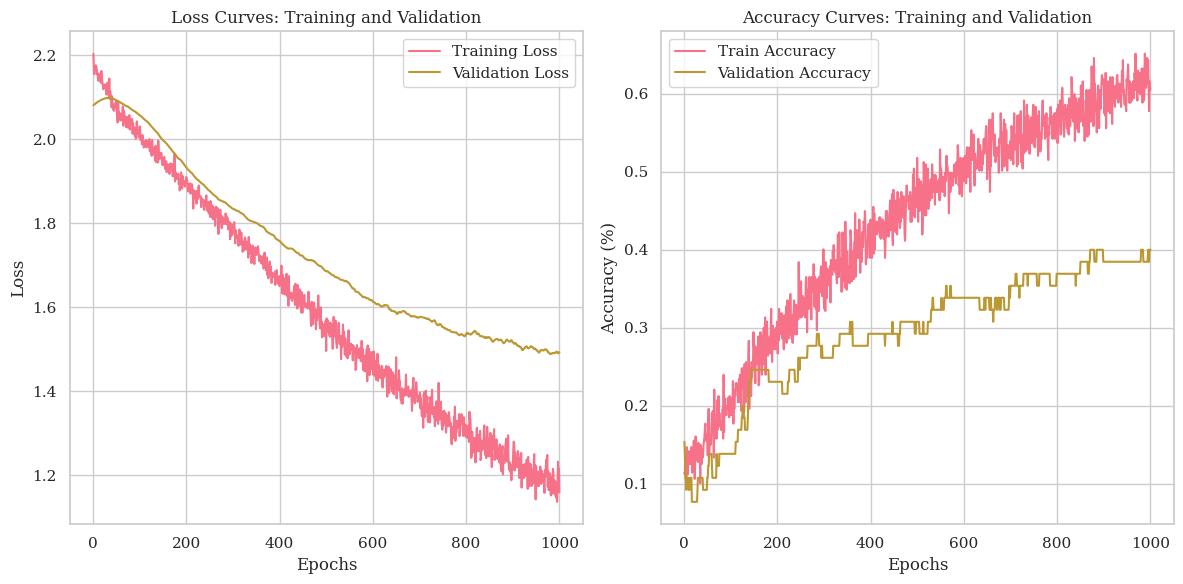

Test set Accuracy: 0.2083
Recall: 0.2083
F1 Score: 0.2152


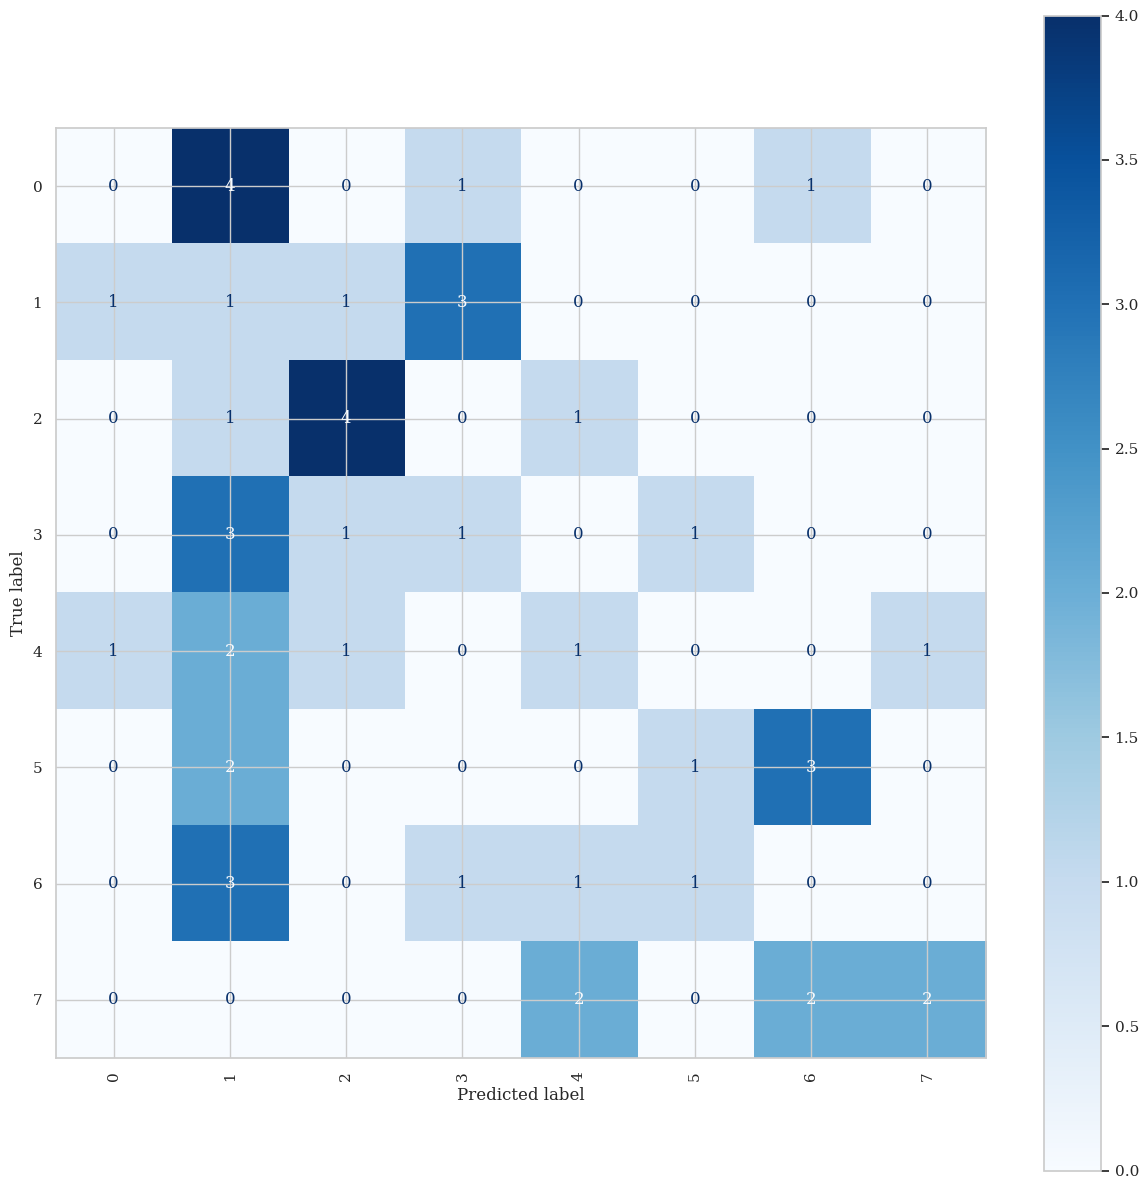

Usuário 7 Finalizado: Acurácia=0.2083, Recall=0.2083, F1=0.2152
--------------------------------------------------
Processando Usuário 8
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1270, Train Accuracy: 0.1308, Val Loss: 2.0768, Val Accuracy: 0.1846
Epoch 2/1000: Train Loss: 2.1370, Train Accuracy: 0.1362, Val Loss: 2.0767, Val Accuracy: 0.1846
Epoch 3/1000: Train Loss: 2.1458, Train Accuracy: 0.1308, Val Loss: 2.0767, Val Accuracy: 0.1538
Epoch 4/1000: Train Loss: 2.1541, Train Accuracy: 0.1253, Val Loss: 2.0767, Val Accuracy: 0.1231
Epoch 5/1000: Train Loss: 2.1398, Train Accuracy: 0.1417, Val Loss: 2.0767, Val Accuracy: 0.1231
Epoch 6/1000: Train Loss: 2.1404, Train Accuracy: 0.1308, Val Loss: 2.0768, Val Accuracy: 0.1077
Epoch 7/1000: Train Loss: 2.1183, Train Accuracy: 0.1253, Val Loss: 2.0769, Val Accuracy: 0.1077
Epoch 8/1000: Train Loss: 2.1336, Train Accuracy: 0.1281, Val Loss: 2.0769, Val Accuracy: 0.1231
Epoch 9/1000: Train Loss: 2.1464, Train Accuracy: 0.1117, Val Loss: 2.0769, Val Accuracy: 0.1538
Epoch 10/1000: Train Loss: 2.1262, Train Accuracy: 0.1090, Val Loss: 2.0769, Val Accuracy: 0.1538
Epoch 11/1000: Train Loss: 2.

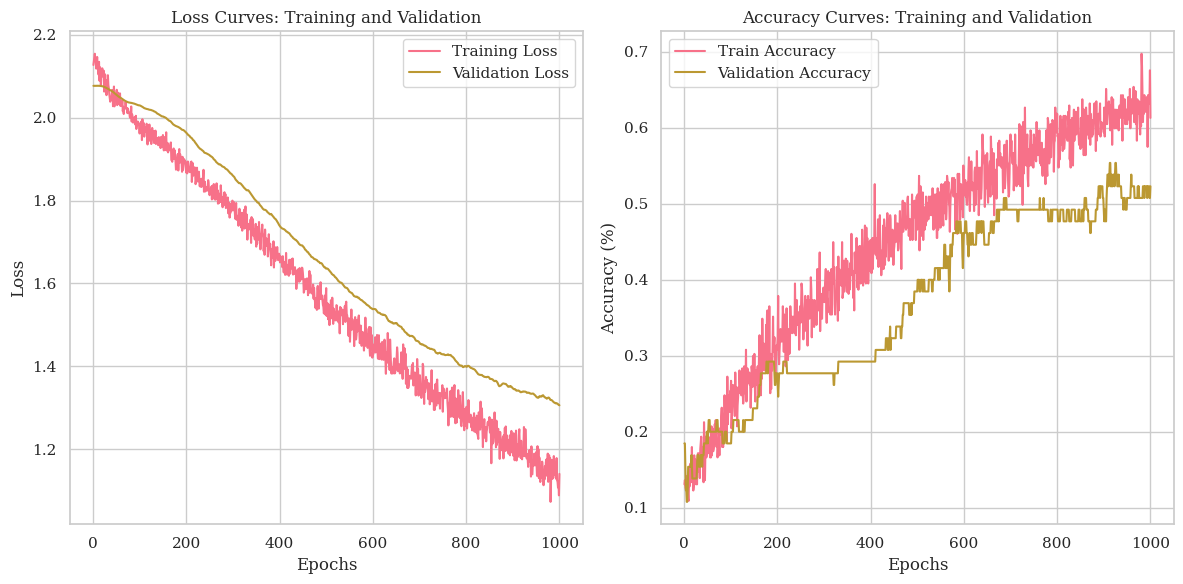

Test set Accuracy: 0.4583
Recall: 0.4583
F1 Score: 0.4368


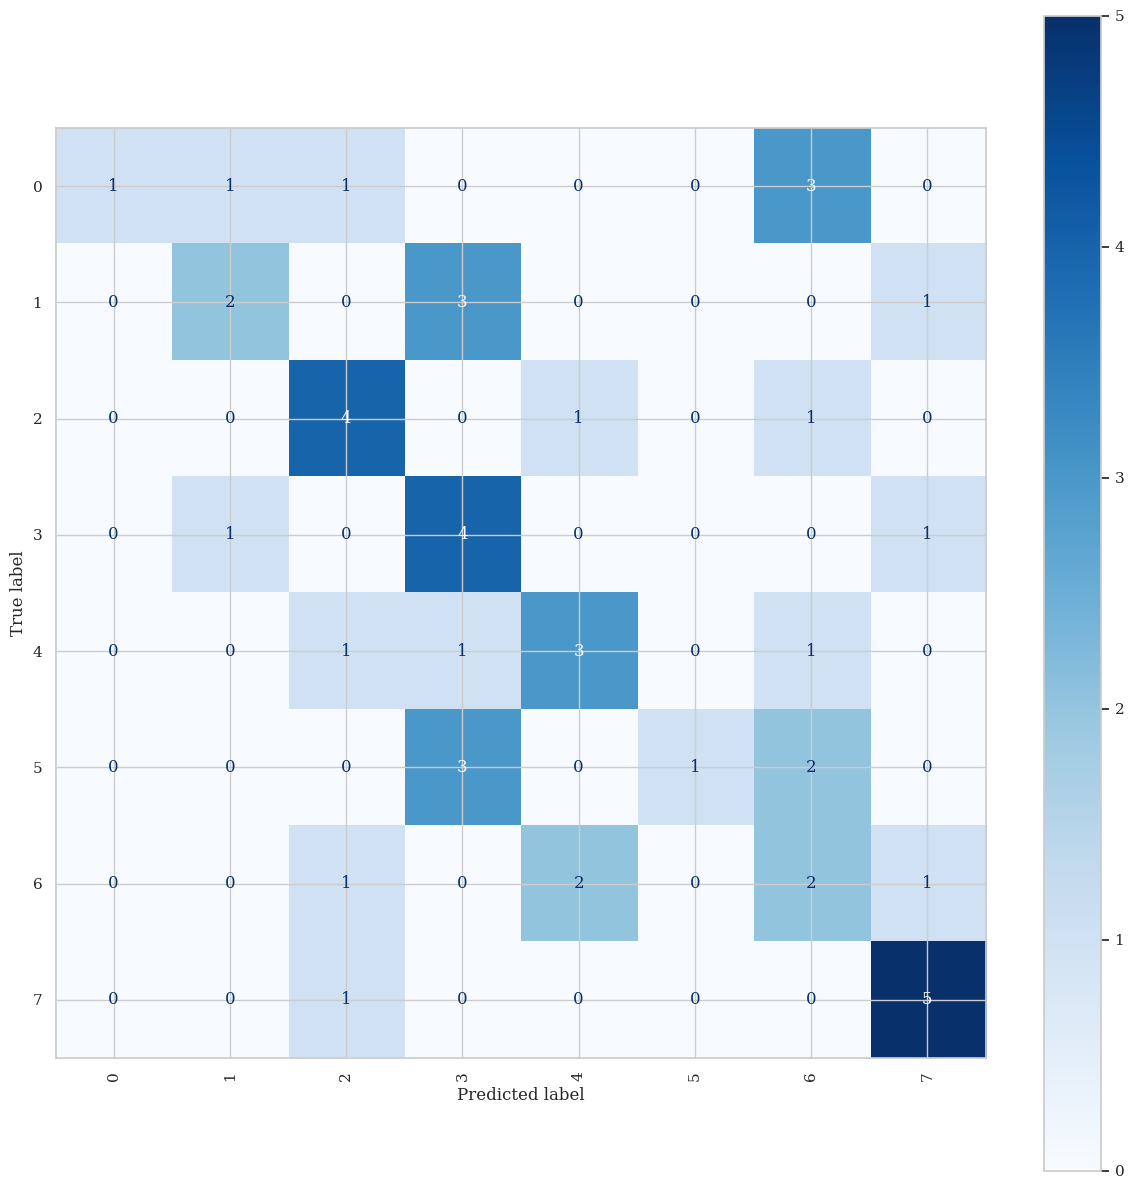

Usuário 8 Finalizado: Acurácia=0.4583, Recall=0.4583, F1=0.4368
--------------------------------------------------
Processando Usuário 9
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1591, Train Accuracy: 0.1144, Val Loss: 2.0929, Val Accuracy: 0.0154
Epoch 2/1000: Train Loss: 2.1527, Train Accuracy: 0.1117, Val Loss: 2.0925, Val Accuracy: 0.0154
Epoch 3/1000: Train Loss: 2.1517, Train Accuracy: 0.1117, Val Loss: 2.0924, Val Accuracy: 0.0615
Epoch 4/1000: Train Loss: 2.1310, Train Accuracy: 0.1362, Val Loss: 2.0924, Val Accuracy: 0.0615
Epoch 5/1000: Train Loss: 2.1293, Train Accuracy: 0.1117, Val Loss: 2.0925, Val Accuracy: 0.0615
Epoch 6/1000: Train Loss: 2.1427, Train Accuracy: 0.1553, Val Loss: 2.0927, Val Accuracy: 0.0615
Epoch 7/1000: Train Loss: 2.1065, Train Accuracy: 0.1417, Val Loss: 2.0929, Val Accuracy: 0.0923
Epoch 8/1000: Train Loss: 2.1369, Train Accuracy: 0.1253, Val Loss: 2.0932, Val Accuracy: 0.0923
Epoch 9/1000: Train Loss: 2.1186, Train Accuracy: 0.1063, Val Loss: 2.0935, Val Accuracy: 0.0923
Epoch 10/1000: Train Loss: 2.1014, Train Accuracy: 0.1580, Val Loss: 2.0939, Val Accuracy: 0.0923
Epoch 11/1000: Train Loss: 2.

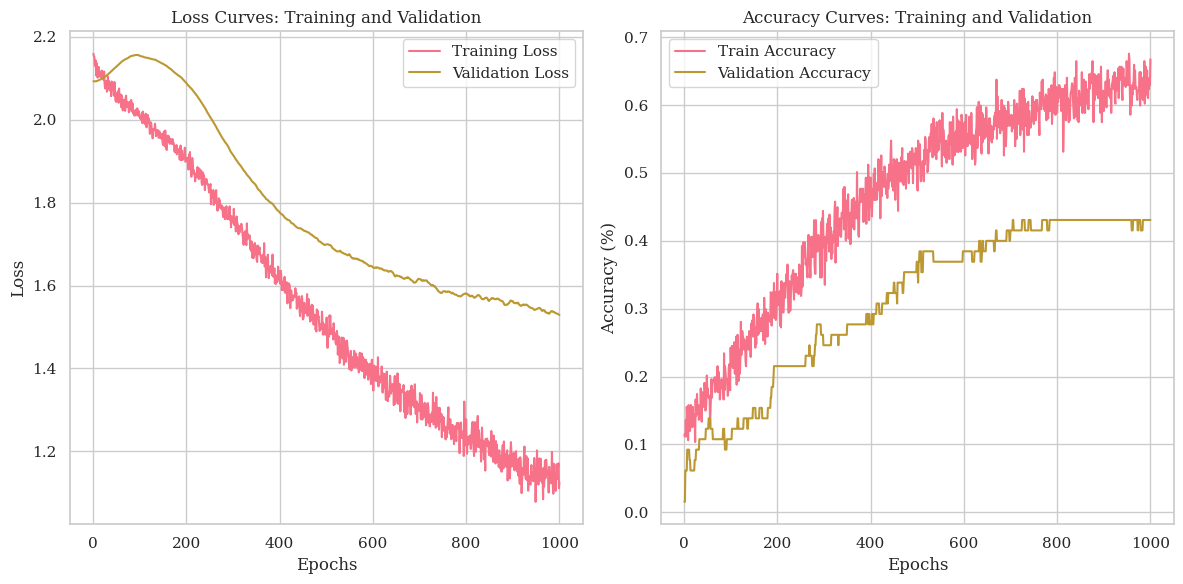

Test set Accuracy: 0.2708
Recall: 0.2708
F1 Score: 0.2339


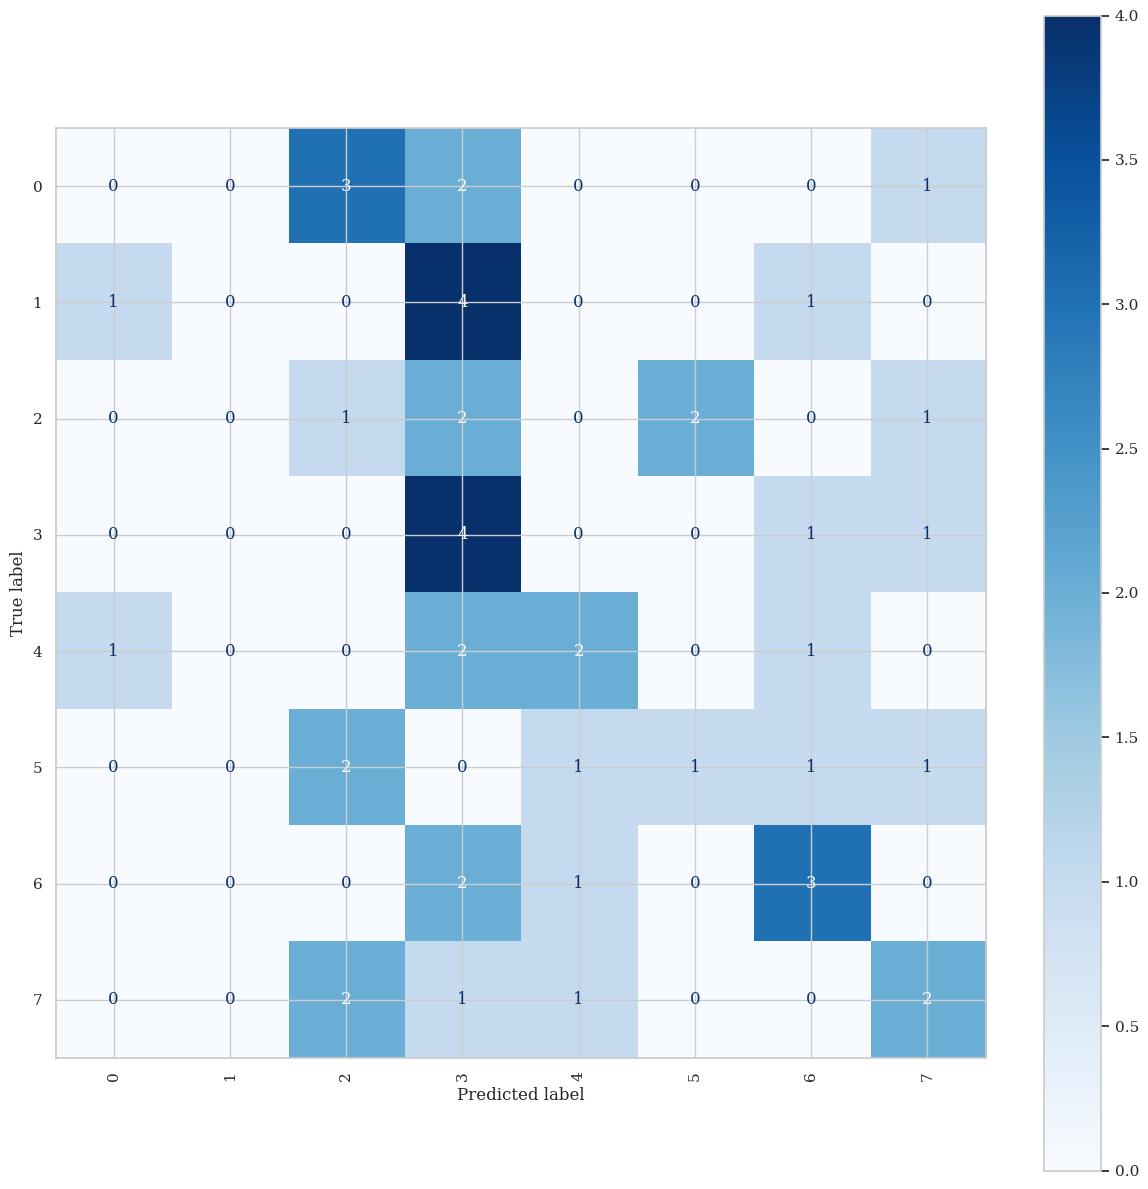

Usuário 9 Finalizado: Acurácia=0.2708, Recall=0.2708, F1=0.2339
--------------------------------------------------
Processando Usuário 10
X_train: torch.Size([432, 9, 100])
X_test: torch.Size([48, 9, 100])
Y_treino: torch.Size([432])
Y_teste: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1324, Train Accuracy: 0.1308, Val Loss: 2.0812, Val Accuracy: 0.0769
Epoch 2/1000: Train Loss: 2.1261, Train Accuracy: 0.1281, Val Loss: 2.0793, Val Accuracy: 0.0462
Epoch 3/1000: Train Loss: 2.1556, Train Accuracy: 0.1144, Val Loss: 2.0779, Val Accuracy: 0.0769
Epoch 4/1000: Train Loss: 2.1261, Train Accuracy: 0.1580, Val Loss: 2.0767, Val Accuracy: 0.0923
Epoch 5/1000: Train Loss: 2.1311, Train Accuracy: 0.1444, Val Loss: 2.0756, Val Accuracy: 0.0923
Epoch 6/1000: Train Loss: 2.1146, Train Accuracy: 0.1553, Val Loss: 2.0745, Val Accuracy: 0.0923
Epoch 7/1000: Train Loss: 2.1196, Train Accuracy: 0.1308, Val Loss: 2.0736, Val Accuracy: 0.0923
Epoch 8/1000: Train Loss: 2.1060, Train Accuracy: 0.1362, Val Loss: 2.0727, Val Accuracy: 0.0923
Epoch 9/1000: Train Loss: 2.1232, Train Accuracy: 0.1253, Val Loss: 2.0718, Val Accuracy: 0.0923
Epoch 10/1000: Train Loss: 2.1066, Train Accuracy: 0.1335, Val Loss: 2.0710, Val Accuracy: 0.1077
Epoch 11/1000: Train Loss: 2.

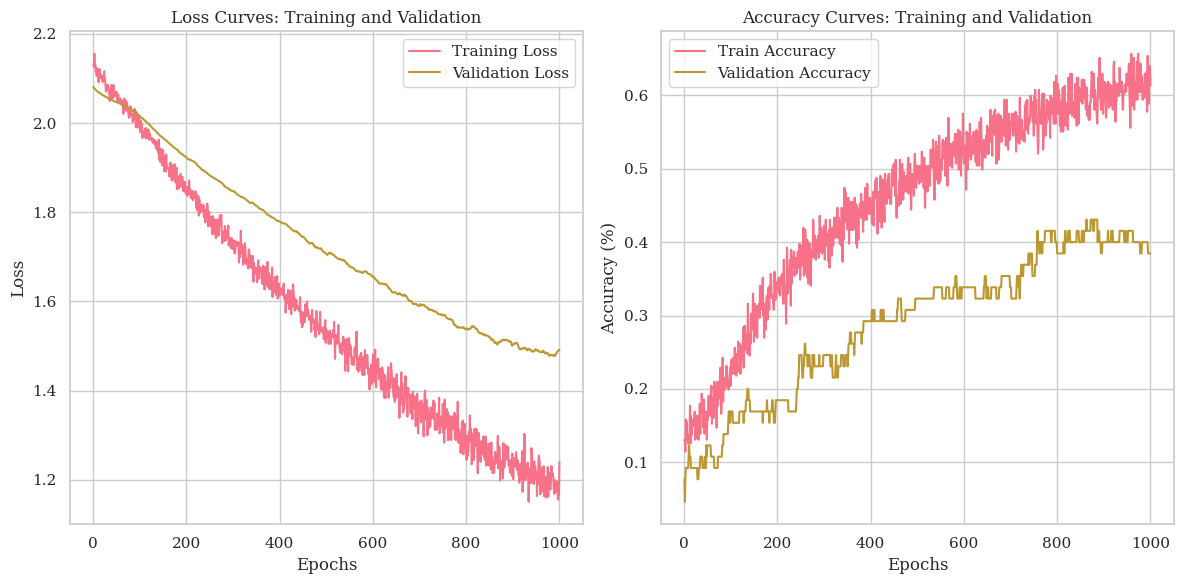

Test set Accuracy: 0.5625
Recall: 0.5625
F1 Score: 0.5397


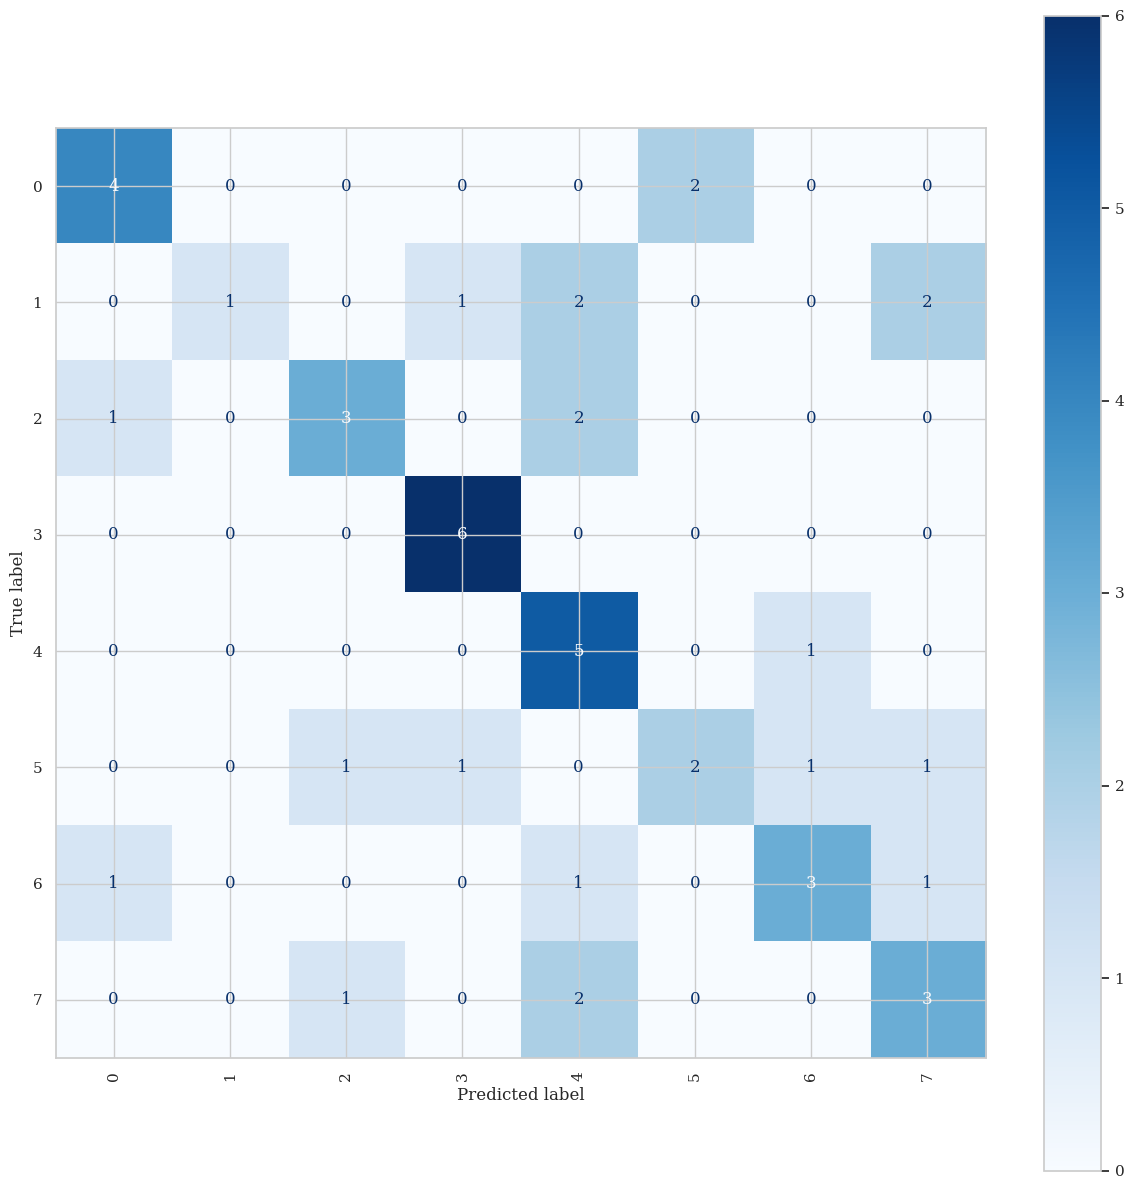

Usuário 10 Finalizado: Acurácia=0.5625, Recall=0.5625, F1=0.5397
--------------------------------------------------


In [ ]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# Lista para armazenar as métricas de todos os usuários
metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

# Leave-one-user-out cross-validation
for user in range(1, len(all_data) + 1):
    print(f"Processando Usuário {user}")
    n_freqs_sel = len(indices)
    metricas_crossval = []
    users_train = [u for u in range(1, len(all_data) + 1) if u != user]
    user_test = user

    x_train = []
    labels_train = []
    x_test = []
    labels_test = []

    # Train data
    for u in users_train:
        data = all_data[u - 1]
        for session in range(data.shape[3]):
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], session]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_train.append(eeg_trial)
                labels_train.extend([frequencias[freq]])
    x_train = np.array(x_train)

    # Test data
    data = all_data[user_test - 1]
    for session in range(data.shape[3]):
        for freq in range(len(indices)):
            eeg_trial = data[occipital_electrodes, :, indices[freq], session]
            eeg_trial = eeg_trial[:, :tamanho_da_janela]
            x_test.append(eeg_trial)
            labels_test.extend([frequencias[freq]])
    x_test = np.array(x_test)

    # Mapeamento de rótulos
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    labels_train = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_train])
    labels_test = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_test])

    # Converter para tensores
    X_train = torch.from_numpy(x_train.copy()).float().to(device)
    X_test = torch.from_numpy(x_test.copy()).float().to(device)
    Y_train = labels_train.to(torch.long).to(device)
    Y_test = labels_test.to(torch.long).to(device)

    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("Y_train:", Y_train.shape)
    print("Y_test:", Y_test.shape)

    # Configurar modelo e treinamento
    model = EEGNetv4(
        n_chans=9,
        n_outputs=len(frequencias_desejadas),
        n_times=tamanho_da_janela,
        kernel_length=(tamanho_da_janela // 2),
    )
    model = model.to(device)

    dataset = TensorDataset(X_train, Y_train)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_test, Y_test), batch_size=10, shuffle=False
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Treinar
    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{user}.pth"),
    )

    # Avaliar
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)

    # Armazenar métricas
    metricas_crossval.append(
        {
            "usuario": user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )

    print(
        f"Usuário {user} Finalizado: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    metricas_usuarios.extend(metricas_crossval)
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath("metricas.csv"), index=False)

    print("-" * 50)

# Leave one-session-out cross validation (DNN and TRCANet style)
Train a general model on 5 sessions, then from there fine-tune a model for each user using his 5 session again and validate on the sixth

In [ ]:
frequencias_e_fases = scipy.io.loadmat(
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
frequencias = frequencias_e_fases["freqs"]
frequencias = np.round(frequencias, 2).ravel()
fases = frequencias_e_fases["phases"]

# Parâmetros de filtragem
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6

# Parâmetros de pré-processamento
sample_rate = 250
delay = 160  # 160 amostras, 0,5s (sem estimulação) + 0,14s (latencia para começo da evocação)

# Parâmetros de janelas e sessões
tamanho_da_janela = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela * sample_rate))

# Eletrodos e frequências de interesse
occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

epochs_general = 3
epochs_fine_tune = 2

exp_dir = Path("leave-one-session-out-10_freqs_1s-test")

In [ ]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

exp_dir.mkdir(parents=True, exist_ok=True)
general_models_dir = exp_dir.joinpath("general_models")
general_models_dir.mkdir(parents=True, exist_ok=True)
fine_tuned_models_dir = exp_dir.joinpath("fine_tuned_models")
fine_tuned_models_dir.mkdir(parents=True, exist_ok=True)

# Lista para armazenar as métricas de todos os usuários e sessões
metricas_usuarios = []

num_sessions = 6
num_users = len(all_data)

for sessao_teste in range(num_sessions):  # Leave-one-session-out
    print(f"Sessão de teste: {sessao_teste}")

    # 1. Treinar modelo geral em 5 sessões de todos os usuários
    x_train_general = []
    y_train_general = []

    for user in range(num_users):
        data = all_data[user]
        for sessao in range(num_sessions):
            if sessao == sessao_teste:
                continue
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], sessao]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_train_general.append(eeg_trial)
                y_train_general.extend([frequencias[freq]])
                # eeg_trial_janelas, numero_janelas = separar_em_janelas(
                #     eeg_trial.T, tamanho_da_janela
                # )
                # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
                # x_train_general.append(eeg_trial_janelas_array)
                # y_train_general.extend([frequencias[freq]] * numero_janelas)

    # x_train_general = np.concatenate(x_train_general, axis=0)
    x_train_general = np.array(x_train_general)

    # Mapeamento de rótulos
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    y_train_general_tensor = torch.tensor(
        [mapeamento[rotulo.item()] for rotulo in y_train_general]
    )

    X_train_general = torch.from_numpy(x_train_general.copy()).float().to(device)
    Y_train_general = y_train_general_tensor.to(torch.long).to(device)

    # Treinar modelo geral
    model_general = EEGNetv4(
        n_chans=9,
        n_outputs=len(frequencias_desejadas),
        n_times=tamanho_da_janela,
        kernel_length=(tamanho_da_janela // 2),
    ).to(device)

    dataset_general = TensorDataset(X_train_general, Y_train_general)
    train_size = int(0.85 * len(dataset_general))
    val_size = len(dataset_general) - train_size
    train_dataset, val_dataset = random_split(
        dataset_general,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_general.parameters(), lr=0.0001)

    print("Treinando modelo geral...")
    best_model_general = train(
        model_general,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs_general,
        device=device,
        save_path=general_models_dir.joinpath(
            f"best_general_model_session_{sessao_teste}.pth"
        ),
    )

    # 2. Para cada usuário, fine-tune e validação na sessão deixada de fora
    for user in range(num_users):
        print(f"Usuário {user+1} - Fine-tuning e validação na sessão {sessao_teste}")
        data = all_data[user]

        # Fine-tune: usar as 5 sessões do usuário exceto a de teste
        x_finetune = []
        y_finetune = []
        for sessao in range(num_sessions):
            if sessao == sessao_teste:
                continue
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], sessao]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_finetune.append(eeg_trial)
                y_finetune.extend([frequencias[freq]])
                # eeg_trial_janelas, numero_janelas = separar_em_janelas(
                #     eeg_trial.T, tamanho_da_janela
                # )
                # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
                # x_finetune.append(eeg_trial_janelas_array)
                # y_finetune.extend([frequencias[freq]] * numero_janelas)

        # x_finetune = np.concatenate(x_finetune, axis=0)
        x_finetune = np.array(x_finetune)
        y_finetune_tensor = torch.tensor(
            [mapeamento[rotulo.item()] for rotulo in y_finetune]
        )

        X_finetune = torch.from_numpy(x_finetune.copy()).float().to(device)
        Y_finetune = y_finetune_tensor.to(torch.long).to(device)

        # Teste: usar a sessão deixada de fora
        x_test = []
        y_test = []
        for freq in range(len(indices)):
            eeg_trial = data[occipital_electrodes, :, indices[freq], sessao_teste]
            eeg_trial = eeg_trial[:, :tamanho_da_janela]
            x_test.append(eeg_trial)
            y_test.extend([frequencias[freq]])
            # eeg_trial_janelas, numero_janelas = separar_em_janelas(
            #     eeg_trial.T, tamanho_da_janela
            # )
            # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
            # x_test.append(eeg_trial_janelas_array)
            # y_test.extend([frequencias[freq]] * numero_janelas)
        # x_test = np.concatenate(x_test, axis=0)
        x_test = np.array(x_test)
        y_test_tensor = torch.tensor([mapeamento[rotulo.item()] for rotulo in y_test])

        X_test = torch.from_numpy(x_test.copy()).float().to(device)
        Y_test = y_test_tensor.to(torch.long).to(device)

        # Fine-tune: carregar pesos do modelo geral
        model_finetune = EEGNetv4(
            n_chans=9,
            n_outputs=len(frequencias_desejadas),
            n_times=tamanho_da_janela,
            kernel_length=(tamanho_da_janela // 2),
        ).to(device)
        model_finetune.load_state_dict(best_model_general.state_dict())

        dataset_finetune = TensorDataset(X_finetune, Y_finetune)
        train_size = int(0.85 * len(dataset_finetune))
        val_size = len(dataset_finetune) - train_size
        train_dataset, val_dataset = random_split(
            dataset_finetune,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(seed),
        )
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(
            TensorDataset(X_test, Y_test), batch_size=10, shuffle=False
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_finetune.parameters(), lr=0.00005)

        print("Fine-tuning modelo para o usuário...")
        best_model_finetune = train(
            model_finetune,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            num_epochs=epochs_fine_tune,
            device=device,
        )

        # Avaliar
        accuracy, recall, f1, cm = evaluate(
            best_model_finetune, test_loader, chanels=len(frequencias_desejadas)
        )

        # Armazenar métricas
        metricas_usuarios.append(
            {
                "usuario": user + 1,
                "sessao_teste": sessao_teste,
                "acuracia": accuracy,
                "recall": recall,
                "f1-score": f1,
                "confusion_matrix": cm,
            }
        )

        print(
            f"Usuário {user+1} - Sessão {sessao_teste} Finalizada: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
        )

    print("-" * 50)

    # =====================================
    # Salvar resultados finais em CSV
    # =====================================

    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(
        exp_dir.joinpath(f"{exp_dir}_metricas_leave_one_session_out_finetune.csv"),
        index=False,
    )